# **Monte Carlo**

#### For each simulation path:
1. Merchant Revenue = Σ[Generationₜ × Priceₜ] 
2. Implied $/MWh = Merchant Revenue / Total Generation

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data = pd.read_csv("../data/ERCOT-Historical-Data.csv")
forward = pd.read_csv("../data/ERCOT-Forward-Prices.csv")
# data.head()
forward.head()

,Month,Peak,Off Peak
0,Jan-26,66.41,61.71
1,Feb-26,66.38,59.84
2,Mar-26,47.90,37.77
3,Apr-26,47.59,36.67
4,May-26,49.00,37.22


### **Formulae**
1. Profit = (RT Hub−DA Hub) * Gen
2. **if you’re selling at DA price but exposed to RT:** Profit=(RT Busbar−DA Busbar) * Gen

In [13]:
# Split historical data by peak/off-peak
peak_hist = data[data["P/OP"] == 1]
off_hist = data[data["P/OP"] == 0]

# Fit simple normal distributions
peak_mu, peak_sigma = peak_hist["RT Hub"].mean(), peak_hist["RT Hub"].std()
off_mu, off_sigma = off_hist["RT Hub"].mean(), off_hist["RT Hub"].std()

print(f"Peak: μ={peak_mu:.2f}, σ={peak_sigma:.2f}")
print(f"Off-Peak: μ={off_mu:.2f}, σ={off_sigma:.2f}")

Peak: μ=47.72, σ=121.02
Off-Peak: μ=32.05, σ=44.62


In [14]:
N = 10000  # number of Monte Carlo runs
sim_results = []

for _, row in forward.iterrows():
    month = row["Month"]
    fwd_peak = row["Peak"]
    fwd_off = row["Off Peak"]
    
    # Generate random scenarios
    peak_sim = np.random.normal(fwd_peak, peak_sigma, N)
    off_sim = np.random.normal(fwd_off, off_sigma, N)
    
    # Aggregate statistics
    peak_mean = peak_sim.mean()
    off_mean = off_sim.mean()
    peak_var95 = np.percentile(peak_sim, 5)
    off_var95 = np.percentile(off_sim, 5)
    
    sim_results.append({
        "Month": month,
        "Fwd_Peak": fwd_peak,
        "Sim_Peak_Mean": peak_mean,
        "Peak_VaR_95": peak_var95,
        "Fwd_Off": fwd_off,
        "Sim_Off_Mean": off_mean,
        "Off_VaR_95": off_var95
    })

results = pd.DataFrame(sim_results)
print(results.head())


    Month  Fwd_Peak  Sim_Peak_Mean  Peak_VaR_95  Fwd_Off  Sim_Off_Mean  \
0  Jan-26     66.41      67.493353  -129.700552    61.71     62.540414   
1  Feb-26     66.38      65.681404  -134.760354    59.84     59.779438   
2  Mar-26     47.90      48.284149  -149.748673    37.77     37.537119   
3  Apr-26     47.59      47.329648  -149.050000    36.67     35.751740   
4  May-26     49.00      47.348531  -149.654401    37.22     37.281575   

   Off_VaR_95  
0   -9.671668  
1  -15.024890  
2  -36.282673  
3  -37.439939  
4  -36.113476  


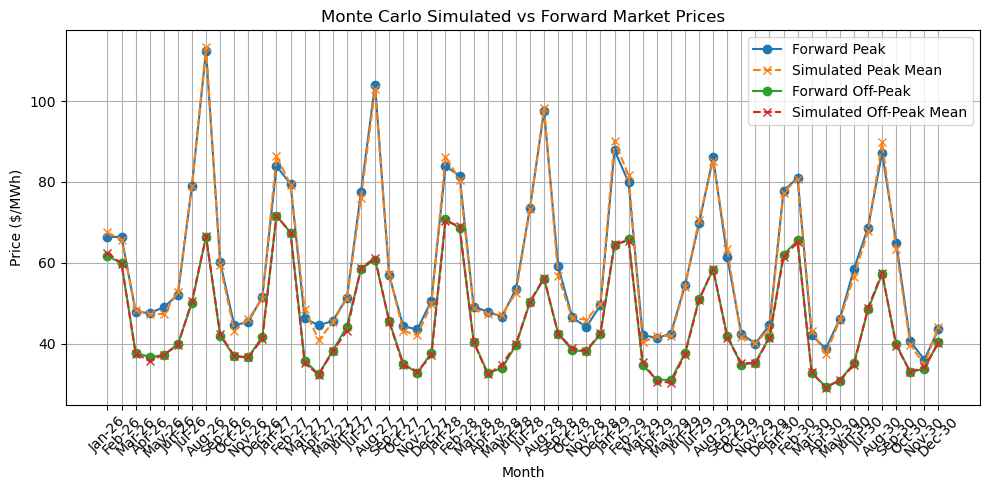

In [15]:
plt.figure(figsize=(10,5))
plt.plot(results["Month"], results["Fwd_Peak"], 'o-', label="Forward Peak")
plt.plot(results["Month"], results["Sim_Peak_Mean"], 'x--', label="Simulated Peak Mean")
plt.plot(results["Month"], results["Fwd_Off"], 'o-', label="Forward Off-Peak")
plt.plot(results["Month"], results["Sim_Off_Mean"], 'x--', label="Simulated Off-Peak Mean")

plt.title("Monte Carlo Simulated vs Forward Market Prices")
plt.xlabel("Month")
plt.ylabel("Price ($/MWh)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()